In [5]:
import sqlalchemy
import configparser
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
config = configparser.ConfigParser()
config_file = '../config.ini'
config.read(config_file)
default = config['DEFAULT-SQLALCHEMY']
engine = sqlalchemy.create_engine('mysql+mysqlconnector://{0}:{1}@{2}/{3}'.
                                            format(default['DB_USER'], default['DB_PASSWORD'], 
                                                    default['DB_IP'], default['DB_DATABASE']))

In [3]:
labelled_df = pd.read_csv('clean_d_tweets.csv')
df = pd.DataFrame(labelled_df['tweet'])
df['tweet'] = df['tweet'].astype(str)
df['tweet_string'] = df['tweet']
df

,tweet,tweet_string
0,the real reason why you be sad you be attach t...,the real reason why you be sad you be attach t...
1,my biggest problem be overthinking everything,my biggest problem be overthinking everything
2,the worst sadness be the sadness you have teac...,the worst sadness be the sadness you have teac...
3,i cannot make you understand i cannot make any...,i cannot make you understand i cannot make any...
4,i do not think anyone really understand how ti...,i do not think anyone really understand how ti...
...,...,...
3077,cough sneeze be tho worst,cough sneeze be tho worst
3078,i can be your sad whore ahaha,i can be your sad whore ahaha
3079,bro that feel you get after you sneeze,bro that feel you get after you sneeze
3080,long piss be the best,long piss be the best


#### Tokenization

In [4]:
from nltk.tokenize import word_tokenize

df['tweet'] = df['tweet'].apply(lambda x: word_tokenize(x))

df.head()

,tweet,tweet_string
0,"[the, real, reason, why, you, be, sad, you, be...",the real reason why you be sad you be attach t...
1,"[my, biggest, problem, be, overthinking, every...",my biggest problem be overthinking everything
2,"[the, worst, sadness, be, the, sadness, you, h...",the worst sadness be the sadness you have teac...
3,"[i, can, not, make, you, understand, i, can, n...",i cannot make you understand i cannot make any...
4,"[i, do, not, think, anyone, really, understand...",i do not think anyone really understand how ti...


#### Stemming

In [5]:
from nltk.stem import PorterStemmer

porterstemmer = PorterStemmer()
df['port_tweet'] = df['tweet'].apply(lambda x: [porterstemmer.stem(word) for word in x])

df.head()

,tweet,tweet_string,port_tweet
0,"[the, real, reason, why, you, be, sad, you, be...",the real reason why you be sad you be attach t...,"[the, real, reason, whi, you, be, sad, you, be..."
1,"[my, biggest, problem, be, overthinking, every...",my biggest problem be overthinking everything,"[my, biggest, problem, be, overthink, everyth]"
2,"[the, worst, sadness, be, the, sadness, you, h...",the worst sadness be the sadness you have teac...,"[the, worst, sad, be, the, sad, you, have, tea..."
3,"[i, can, not, make, you, understand, i, can, n...",i cannot make you understand i cannot make any...,"[i, can, not, make, you, understand, i, can, n..."
4,"[i, do, not, think, anyone, really, understand...",i do not think anyone really understand how ti...,"[i, do, not, think, anyon, realli, understand,..."


#### Removal of Stop words

In [6]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')

def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

df['port_tweet'] = df['port_tweet'].apply(remove_stopwords)

df.head()

,tweet,tweet_string,port_tweet
0,"[the, real, reason, why, you, be, sad, you, be...",the real reason why you be sad you be attach t...,"[real, reason, whi, sad, attach, peopl, distan..."
1,"[my, biggest, problem, be, overthinking, every...",my biggest problem be overthinking everything,"[biggest, problem, overthink, everyth]"
2,"[the, worst, sadness, be, the, sadness, you, h...",the worst sadness be the sadness you have teac...,"[worst, sad, sad, teach, hide]"
3,"[i, can, not, make, you, understand, i, can, n...",i cannot make you understand i cannot make any...,"[make, understand, make, anyon, understand, ha..."
4,"[i, do, not, think, anyone, really, understand...",i do not think anyone really understand how ti...,"[think, anyon, realli, understand, tire, act, ..."


#### VADER

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment_analyzer = SentimentIntensityAnalyzer()
df['score'] = df['port_tweet'].apply(lambda x: sentiment_analyzer.polarity_scores(x)['compound'])

df['score'] = np.where(df['score'] < 0, 'Negative', np.where(df['score'] == 0, 'Neutral', 'Positive'))
df['score'].value_counts()

score
Neutral     3017
Negative      38
Positive      27
Name: count, dtype: int64

#### SentiWordNet

In [8]:
def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [9]:
make_sentences(df,'port_tweet')

In [10]:
pos=neg=obj=count=0

postagging = []

for review in df['port_tweet']:
    list = word_tokenize(review)
    postagging.append(nltk.pos_tag(list))

df['pos_tags'] = postagging

df.head()

,tweet,tweet_string,port_tweet,score,pos_tags
0,"[the, real, reason, why, you, be, sad, you, be...",the real reason why you be sad you be attach t...,real reason whi sad attach peopl distant pay a...,Neutral,"[(real, JJ), (reason, NN), (whi, NN), (sad, JJ..."
1,"[my, biggest, problem, be, overthinking, every...",my biggest problem be overthinking everything,biggest problem overthink everyth,Neutral,"[(biggest, JJS), (problem, NN), (overthink, NN..."
2,"[the, worst, sadness, be, the, sadness, you, h...",the worst sadness be the sadness you have teac...,worst sad sad teach hide,Neutral,"[(worst, RB), (sad, JJ), (sad, JJ), (teach, NN..."
3,"[i, can, not, make, you, understand, i, can, n...",i cannot make you understand i cannot make any...,make understand make anyon understand happen i...,Neutral,"[(make, NN), (understand, NN), (make, VB), (an..."
4,"[i, do, not, think, anyone, really, understand...",i do not think anyone really understand how ti...,think anyon realli understand tire act okay al...,Neutral,"[(think, VB), (anyon, JJ), (realli, NNS), (und..."


In [1]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def get_sentiment(word,tag):
    wn_tag = penn_to_wn(tag)
    
    if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
        return []

    lemma = lemmatizer.lemmatize(word, pos=wn_tag)
    if not lemma:
        return []
    
    synsets = wn.synsets(word, pos=wn_tag)
    if not synsets:
        return []

    synset = synsets[0]
    swn_synset = swn.senti_synset(synset.name())

    return [synset.name(), swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score()]

    pos=neg=obj=count=0

In [12]:
senti_score = []

for pos_val in df['pos_tags']:
    senti_val = [get_sentiment(x,y) for (x,y) in pos_val]
    for score in senti_val:
        try:
            pos = pos + score[1]  
            neg = neg + score[2]  
        except:
            continue
    senti_score.append(round((pos - neg),2))
    pos=neg=0    
    
df['senti_score'] = senti_score
print(df['senti_score'])

df.head()

0      -0.12
1      -0.50
2      -2.12
3       0.62
4       0.50
        ... 
3077   -0.50
3078   -0.88
3079    0.00
3080    0.75
3081   -0.75
Name: senti_score, Length: 3082, dtype: float64


,tweet,tweet_string,port_tweet,score,pos_tags,senti_score
0,"[the, real, reason, why, you, be, sad, you, be...",the real reason why you be sad you be attach t...,real reason whi sad attach peopl distant pay a...,Neutral,"[(real, JJ), (reason, NN), (whi, NN), (sad, JJ...",-0.12
1,"[my, biggest, problem, be, overthinking, every...",my biggest problem be overthinking everything,biggest problem overthink everyth,Neutral,"[(biggest, JJS), (problem, NN), (overthink, NN...",-0.50
2,"[the, worst, sadness, be, the, sadness, you, h...",the worst sadness be the sadness you have teac...,worst sad sad teach hide,Neutral,"[(worst, RB), (sad, JJ), (sad, JJ), (teach, NN...",-2.12
3,"[i, can, not, make, you, understand, i, can, n...",i cannot make you understand i cannot make any...,make understand make anyon understand happen i...,Neutral,"[(make, NN), (understand, NN), (make, VB), (an...",0.62
4,"[i, do, not, think, anyone, really, understand...",i do not think anyone really understand how ti...,think anyon realli understand tire act okay al...,Neutral,"[(think, VB), (anyon, JJ), (realli, NNS), (und...",0.50


In [13]:
df['senti_score'] = df['senti_score'].replace(0.00, 0)
df['senti_score'] = np.where(df['senti_score'] < 0, 'Negative', np.where(df['senti_score'] == 0, 'Neutral', 'Positive'))
df['senti_score'].value_counts()

senti_score
Neutral     1268
Negative    1036
Positive     778
Name: count, dtype: int64

#### TextBlob

In [14]:
from textblob import TextBlob

def sentiment_analysis(df):
    def getSubjectivity(text):
        return TextBlob(text).sentiment.subjectivity
    
    def getPolarity(text):
        return TextBlob(text).sentiment.polarity

    df['TextBlob_Subjectivity'] = df['tweet_string'].apply(getSubjectivity)
    df['TextBlob_Polarity'] = df['tweet_string'].apply(getPolarity)

    def getAnalysis(score):
        if score < 0:
            return 'Negative'
        elif score == 0:
            return 'Neutral'
        else:
            return 'Positive'
        
    df['TextBlob_Analysis'] = df['TextBlob_Polarity'].apply(getAnalysis )

    return df

sentiment_analysis(df)

,tweet,tweet_string,port_tweet,score,pos_tags,senti_score,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis
0,"[the, real, reason, why, you, be, sad, you, be...",the real reason why you be sad you be attach t...,real reason whi sad attach peopl distant pay a...,Neutral,"[(real, JJ), (reason, NN), (whi, NN), (sad, JJ...",Negative,0.403333,-0.093333,Negative
1,"[my, biggest, problem, be, overthinking, every...",my biggest problem be overthinking everything,biggest problem overthink everyth,Neutral,"[(biggest, JJS), (problem, NN), (overthink, NN...",Negative,0.000000,0.000000,Neutral
2,"[the, worst, sadness, be, the, sadness, you, h...",the worst sadness be the sadness you have teac...,worst sad sad teach hide,Neutral,"[(worst, RB), (sad, JJ), (sad, JJ), (teach, NN...",Negative,1.000000,-1.000000,Negative
3,"[i, can, not, make, you, understand, i, can, n...",i cannot make you understand i cannot make any...,make understand make anyon understand happen i...,Neutral,"[(make, NN), (understand, NN), (make, VB), (an...",Positive,0.000000,0.000000,Neutral
4,"[i, do, not, think, anyone, really, understand...",i do not think anyone really understand how ti...,think anyon realli understand tire act okay al...,Neutral,"[(think, VB), (anyon, JJ), (realli, NNS), (und...",Positive,0.477778,0.377778,Positive
...,...,...,...,...,...,...,...,...,...
3077,"[cough, sneeze, be, tho, worst]",cough sneeze be tho worst,cough sneez tho worst,Neutral,"[(cough, NN), (sneez, NN), (tho, NN), (worst, ...",Negative,1.000000,-1.000000,Negative
3078,"[i, can, be, your, sad, whore, ahaha]",i can be your sad whore ahaha,sad whore ahaha,Neutral,"[(sad, JJ), (whore, NN), (ahaha, NN)]",Negative,1.000000,-0.500000,Negative
3079,"[bro, that, feel, you, get, after, you, sneeze]",bro that feel you get after you sneeze,bro feel get sneez,Neutral,"[(bro, NN), (feel, VB), (get, NN), (sneez, NN)]",Neutral,0.000000,0.000000,Neutral
3080,"[long, piss, be, the, best]",long piss be the best,long piss best,Neutral,"[(long, RB), (piss, JJ), (best, JJS)]",Positive,0.350000,0.475000,Positive


In [15]:
df['TextBlob_Analysis'].value_counts()

TextBlob_Analysis
Neutral     1249
Positive     979
Negative     854
Name: count, dtype: int64

In [1]:
import pandas as pd

reddit_df = pd.read_csv('../Reddit Data/final_dataset_2024-03-23.csv', index_col=0)
reddit_df = reddit_df.rename(columns={'preprocessed-text-removal': 'text'})
reddit_df['text'] = reddit_df['text'].astype('str')

reddit_df.dtypes

text         object
sentiment    object
dtype: object

In [3]:
def preprocess_Reviews_data(data,name):
    # Proprocessing the data
    data[name]=data[name].str.lower()
    # Code to remove the Hashtags from the text
    data[name]=data[name].apply(lambda x:re.sub(r'\B#\S+','',x))
    # Code to remove the links from the text
    data[name]=data[name].apply(lambda x:re.sub(r"http\S+", "", x))
    # Code to remove the Special characters from the text 
    data[name]=data[name].apply(lambda x:' '.join(re.findall(r'\w+', x)))
    # Code to substitute the multiple spaces with single spaces
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
    # Code to remove all the single characters in the text
    data[name]=data[name].apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))
    # Remove the twitter handlers
    data[name]=data[name].apply(lambda x:re.sub('@[^\s]+','',x))

# Function to tokenize and remove the stopwords    
def rem_stopwords_tokenize(data,name):
      
    def getting(sen):
        example_sent = sen
        
        filtered_sentence = [] 

        stop_words = set(stopwords.words('english')) 

        word_tokens = word_tokenize(example_sent) 
        
        filtered_sentence = [w for w in word_tokens if not w in stop_words] 
        
        return filtered_sentence
    # Using "getting(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting(i))
    data[name]=x

lemmatizer = WordNetLemmatizer()
def Lemmatization(data,name):
    def getting2(sen):
        
        example = sen
        output_sentence =[]
        word_tokens2 = word_tokenize(example)
        lemmatized_output = [lemmatizer.lemmatize(w) for w in word_tokens2]
        
        # Remove characters which have length less than 2  
        without_single_chr = [word for word in lemmatized_output if len(word) > 2]
        # Remove numbers
        cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]
        
        return cleaned_data_title
    # Using "getting2(sen)" function to append edited sentence to data
    x=[]
    for i in data[name].values:
        x.append(getting2(i))
    data[name]=x

def make_sentences(data,name):
    data[name]=data[name].apply(lambda x:' '.join([i+' ' for i in x]))
    # Removing double spaces if created
    data[name]=data[name].apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [6]:
preprocess_Reviews_data(reddit_df,'text')
rem_stopwords_tokenize(reddit_df,'text')
make_sentences(reddit_df,'text')

#Edits After Lemmatization
final_Edit = reddit_df['text'].copy()
reddit_df["new_text"] = final_Edit

# Using the Lemmatization function to lemmatize the hotel data
Lemmatization(reddit_df,'new_text')
# Converting all the texts back to sentences
make_sentences(reddit_df,'new_text')

reddit_df.head()

,text,sentiment,new_text
0,therapist told trust issue,positive,therapist told trust issue
1,believe,neutral,believe
2,think internet ruined know anymore,negative,think internet ruined know anymore
3,hi longest time wondering enjoy anything anymo...,negative,longest time wondering enjoy anything anymore ...
4,masturbation guilt,negative,masturbation guilt


In [7]:
reddit_df.sentiment.value_counts()

sentiment
negative    13865
positive     9304
neutral      6357
Name: count, dtype: int64

#### Bag of Words

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer


reddit_df['text_new'] = reddit_df['new_text'].copy()

vec = CountVectorizer()
X = vec.fit_transform(reddit_df['text_new'])
df = pd.DataFrame(X.toarray(), columns = vec.get_feature_names_out())

vect = CountVectorizer()
vect.fit(reddit_df['text_new'])
vect.get_feature_names_out()
simple_train_dtm = vect.transform(reddit_df['text_new'])

bow_counts = CountVectorizer(tokenizer= word_tokenize,
                             ngram_range=(1,3))

bow_data = bow_counts.fit_transform(reddit_df['text_new'])

c:\Users\Willis\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [9]:
from sklearn.model_selection import train_test_split
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(bow_data,
                                                                    reddit_df['sentiment'],
                                                                    test_size = 0.25,
                                                                    random_state = 0)

#### TF-IDF

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
noise_words = []
tfidf_counts = TfidfVectorizer(tokenizer= word_tokenize,
                               stop_words=noise_words,
                               ngram_range=(1,1)) 

tfidf_data = tfidf_counts.fit_transform(reddit_df['text_new'])

In [11]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data,
                                                                            reddit_df['sentiment'],
                                                                            test_size = 0.25,
                                                                            random_state = 0)

#### SMOTE Sampling

In [12]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

smote = SMOTE(random_state=42)
X_train_bow_smote, y_train_bow_smote= smote.fit_resample(X_train_bow, y_train_bow)

In [13]:
X_train_tfidf_smote, y_train_tfidf_smote= smote.fit_resample(X_train_tfidf, y_train_tfidf)

#### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_bow, y_train_bow)

y_pred = lr.predict(X_test_bow)

from sklearn.metrics import classification_report
print(classification_report(y_test_bow,y_pred))

              precision    recall  f1-score   support

    negative       0.95      0.94      0.94      3456
     neutral       0.92      0.99      0.95      1616
    positive       0.93      0.89      0.91      2310

    accuracy                           0.94      7382
   macro avg       0.93      0.94      0.94      7382
weighted avg       0.94      0.94      0.94      7382



c:\Users\Willis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_bow_smote, y_train_bow_smote)

y_pred = lr.predict(X_test_bow)

from sklearn.metrics import classification_report
print(classification_report(y_test_bow,y_pred))

              precision    recall  f1-score   support

    negative       0.96      0.92      0.94      3456
     neutral       0.91      0.98      0.94      1616
    positive       0.91      0.91      0.91      2310

    accuracy                           0.93      7382
   macro avg       0.93      0.94      0.93      7382
weighted avg       0.93      0.93      0.93      7382



c:\Users\Willis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [19]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train_tfidf)

y_pred = lr.predict(X_test_tfidf)

from sklearn.metrics import classification_report
print(classification_report(y_test_tfidf,y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.93      0.92      3456
     neutral       0.93      0.95      0.94      1616
    positive       0.90      0.86      0.88      2310

    accuracy                           0.91      7382
   macro avg       0.92      0.91      0.91      7382
weighted avg       0.91      0.91      0.91      7382



c:\Users\Willis\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### SVM

In [21]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_bow, y_train_bow)

y_pred = svm.predict(X_test_bow)

from sklearn.metrics import classification_report
print(classification_report(y_test_bow,y_pred))

              precision    recall  f1-score   support

    negative       0.85      0.88      0.86      3456
     neutral       0.74      0.94      0.83      1616
    positive       0.90      0.68      0.77      2310

    accuracy                           0.83      7382
   macro avg       0.83      0.83      0.82      7382
weighted avg       0.84      0.83      0.83      7382



In [25]:
from sklearn.svm import SVC
svm = SVC()
svm.fit(X_train_tfidf, y_train_tfidf)

y_pred = svm.predict(X_test_tfidf)

from sklearn.metrics import classification_report
print(classification_report(y_test_tfidf,y_pred))

              precision    recall  f1-score   support

    negative       0.93      0.95      0.94      3456
     neutral       0.95      0.95      0.95      1616
    positive       0.94      0.90      0.92      2310

    accuracy                           0.94      7382
   macro avg       0.94      0.93      0.94      7382
weighted avg       0.94      0.94      0.94      7382



#### Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier()
dc.fit(X_train_bow, y_train_bow)

y_pred = dc.predict(X_test_bow)

from sklearn.metrics import classification_report
print(classification_report(y_test_bow,y_pred))

              precision    recall  f1-score   support

    negative       0.90      0.89      0.90      3456
     neutral       0.93      0.99      0.96      1616
    positive       0.86      0.83      0.85      2310

    accuracy                           0.90      7382
   macro avg       0.90      0.90      0.90      7382
weighted avg       0.90      0.90      0.90      7382



In [27]:
from sklearn.tree import DecisionTreeClassifier
dc = DecisionTreeClassifier()
dc.fit(X_train_tfidf, y_train_tfidf)

y_pred = dc.predict(X_test_tfidf)

from sklearn.metrics import classification_report
print(classification_report(y_test_tfidf,y_pred))

              precision    recall  f1-score   support

    negative       0.89      0.89      0.89      3456
     neutral       0.93      0.97      0.95      1616
    positive       0.85      0.83      0.84      2310

    accuracy                           0.89      7382
   macro avg       0.89      0.90      0.89      7382
weighted avg       0.89      0.89      0.89      7382



#### Naive Bayes Classification

In [28]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_bow, y_train_bow)

y_pred = nb.predict(X_test_bow)

from sklearn.metrics import classification_report
print(classification_report(y_test_bow, y_pred))

              precision    recall  f1-score   support

    negative       0.75      0.88      0.81      3456
     neutral       1.00      0.42      0.59      1616
    positive       0.74      0.86      0.80      2310

    accuracy                           0.77      7382
   macro avg       0.83      0.72      0.73      7382
weighted avg       0.80      0.77      0.76      7382



In [14]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_bow_smote, y_train_bow_smote)

y_pred = nb.predict(X_test_bow)

from sklearn.metrics import classification_report
print(classification_report(y_test_bow, y_pred))

              precision    recall  f1-score   support

    negative       0.82      0.86      0.84      3456
     neutral       0.99      0.45      0.62      1616
    positive       0.70      0.91      0.79      2310

    accuracy                           0.79      7382
   macro avg       0.84      0.74      0.75      7382
weighted avg       0.82      0.79      0.78      7382



In [29]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train_tfidf)

y_pred = nb.predict(X_test_tfidf)

from sklearn.metrics import classification_report
print(classification_report(y_test_tfidf, y_pred))

              precision    recall  f1-score   support

    negative       0.66      0.96      0.78      3456
     neutral       0.98      0.49      0.65      1616
    positive       0.85      0.57      0.68      2310

    accuracy                           0.73      7382
   macro avg       0.83      0.67      0.70      7382
weighted avg       0.79      0.73      0.72      7382



In [15]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf_smote, y_train_tfidf_smote)

y_pred = nb.predict(X_test_tfidf)

from sklearn.metrics import classification_report
print(classification_report(y_test_tfidf, y_pred))

              precision    recall  f1-score   support

    negative       0.83      0.85      0.84      3456
     neutral       0.97      0.65      0.78      1616
    positive       0.71      0.84      0.77      2310

    accuracy                           0.81      7382
   macro avg       0.84      0.78      0.80      7382
weighted avg       0.82      0.81      0.80      7382



In [20]:
df = pd.read_excel('../Reddit Data/model loss.xlsx')
df.head()

,learning_rate,optimizer,epoch_10,epoch_20,epoch_30,epoch_40,epoch_50,epoch_60,epoch_70,epoch_80,epoch_90,epoch_100
0,0.0100,SGD,0.6656,0.4095,0.2598,0.1710,0.1923,0.1024,0.0587,0.0755,0.0351,0.0468
1,0.0010,SGD,1.0224,1.0198,0.9650,0.9118,0.9000,0.8451,0.8281,0.7805,0.7427,0.6931
2,0.0005,SGD,1.0481,1.0240,1.0101,1.0043,0.9827,0.9701,0.9451,0.9073,0.9060,0.8920
3,0.0001,SGD,1.0868,1.0785,1.0633,1.0590,1.0577,1.0469,1.0512,1.0513,1.0363,1.0450
4,0.0100,Adam,0.0003,0.0004,0.0004,0.0036,0.0015,0.0001,0.0009,0.0002,0.0001,0.0002


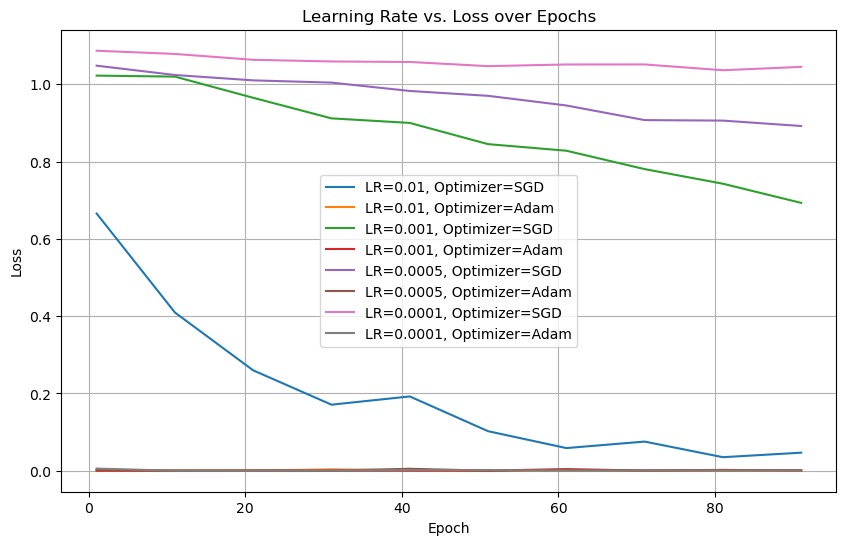

In [22]:
import matplotlib.pyplot as plt

learning_rates = df['learning_rate'].unique()
optimizers = df['optimizer'].unique()
epochs = range(1, 100, 10)

plt.figure(figsize=(10, 6))

for lr in learning_rates:
    for optimizer in optimizers:
        optimizer_data = df[(df['learning_rate'] == lr) & (df['optimizer'] == optimizer)]
        plt.plot(epochs, optimizer_data.iloc[0, 2:], label=f'LR={lr}, Optimizer={optimizer}')

plt.title('Learning Rate vs. Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
